In [1]:
import dask, concurrent.futures, time, warnings, os, re, pickle
from osgeo import gdal
import os
import requests as r
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import rioxarray as riox
import time
import xarray as xr
from urllib.request import urlopen
from xml.etree.ElementTree import parse,fromstring
from pandas import to_datetime
from rasterio.crs import CRS
from datetime import datetime, timedelta
from netrc import netrc
from pyproj import Proj
from src.hls_funcs import fetch
from src.hls_funcs.masks import mask_hls, shp2mask, bolton_mask
from src.hls_funcs.indices import ndvi_func
from src.hls_funcs.smooth import smooth_xr, despike_ts_xr
import cartopy.crs as ccrs
from rasterio.plot import show
from src.hls_funcs.predict import pred_bm
import dask.diagnostics
import matplotlib.pyplot as plt

In [2]:
t00 = time.time()
os.chdir('/project/cper_neon_aop/hls_nrt/')

In [3]:
"""
Get the server base url
"""
from jupyter_server import serverapp
from jupyter_server.utils import url_path_join
from pathlib import Path
import re
import requests
 
jupServer = [x for x in serverapp.list_running_servers()][0]

In [4]:
#aoi_f = os.path.join('data/ground/cper_pastures_2017_clip.shp')
#df_aoi = gpd.read_file(aoi_f)
#outDIR = '/project/cper_neon_aop/hls_nrt/'
from src.utils.convert import kmz_to_shp
df_aoi = kmz_to_shp('data/ground/RedTop_Boundary.kmz', 'data/ground/')
df_aoi = df_aoi.to_crs(epsg=32613)
prefix = 'redtop' 
#prefix = 'cper'
outDIR = '/90daydata/cper_neon_aop/hls_nrt/' + prefix
subunit_name_old = None #'Past_Name_'
subunit_name = None #'Pasture'
mod_bm = pickle.load(open('src/models/CPER_HLS_to_VOR_biomass_model_lr_simp.pk', 'rb'))

In [5]:
yr = 2022

In [6]:
print(yr)
t0 = time.time()
cluster_loc = 'hpc'
t1 = time.time()
if cluster_loc == 'local':
    print('   setting up Local cluster...')
    from dask.distributed import LocalCluster, Client
    import dask
    aws=False
    fetch.setup_env(aws=aws)
    cluster = LocalCluster(n_workers=8, threads_per_worker=2)
    client = Client(cluster)
    display(client)
elif cluster_loc == 'coiled':
    import coiled
    aws=True
    fetch.setup_env(aws=aws)
    s3_cred = fetch.setup_netrc(creds=['spkearney', '1mrChamu'], aws=aws)
    coiled.create_software_environment(
    name="hls_cog_coiled",
    conda="hls_cog_coiled_env.yaml")
    cluster = coiled.Cluster(
        name="hls_cog_coiled",
        software="kearney-sp/hls_cog_coiled",
        n_workers=5,
        worker_cpu=2,
        scheduler_cpu=2,
        backend_options={"region": "us-west-2"},
        environ=dict(GDAL_DISABLE_READDIR_ON_OPEN='FALSE', 
                   #AWS_NO_SIGN_REQUEST='YES',
                   GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
                   GDAL_SWATH_SIZE='200000000',
                   VSI_CURL_CACHE_SIZE='200000000',
                   CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                   GDAL_HTTP_UNSAFESSL='YES',
                   GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                   GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'),
                   AWS_REGION='us-west-2',
                   AWS_SECRET_ACCESS_KEY=s3_cred['secretAccessKey'],
                   AWS_ACCESS_KEY_ID=s3_cred['accessKeyId'],
                   AWS_SESSION_TOKEN=s3_cred['sessionToken'])
    )
    client = Client(cluster)
    display(client)
elif cluster_loc == 'hpc':
    from dask.distributed import LocalCluster, Client
    import dask_jobqueue as jq
    import dask
    print('   setting up moderate cluster on HPC...')
    aws=False
    fetch.setup_env(aws=aws)
    dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
    partition='brief-low',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 2.5*num_processes*num_threads_per_processes
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=2
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

if not os.path.exists(outDIR):
    os.mkdir(outDIR)

if subunit_name_old is not None:
    df_aoi = df_aoi.rename(columns={subunit_name_old: subunit_name})
if subunit_name is not None:
    df_aoi = df_aoi.dissolve(by=subunit_name).reset_index()

start_date = str(yr - 1) + "-11-01"
end_date = str(yr + 1) + "-03-01"

# set the date range for analysis
date_rng = pd.date_range(start=start_date, end=end_date)
date_rng = date_rng[date_rng <= datetime.today()]

2022


/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


   setting up moderate cluster on HPC...


<Client: 'tcp://10.1.9.227:45679' processes=0 threads=0, memory=0 B>

...completed in 13.0 secs
total elasped time: 0.22 mins



In [ ]:
print('   fetching data...')
t1 = time.time()
# fetch the COG data from the AWS bucket
data_dict = {'date_range': [str(date_rng.min().date()), str(date_rng.max().date())]}
hls_ds = fetch.get_hls(hls_data=data_dict,
                       bbox=df_aoi.total_bounds, 
                       proj_epsg=df_aoi.crs.to_epsg(),
                       lim=500,
                       aws=aws)
hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] != None, drop=True)
hls_ds = hls_ds.where(hls_ds['eo:cloud_cover'] < 90, drop=True)
#hls_ds = hls_ds.loc[dict(x=slice(517587.0, 527283.0), y=slice(4524402.0, 4514699.0))].chunk({'y': -1,
#                                                                                             'x': -1,
#                                                                                             'time':1})
hls_mask = mask_hls(hls_ds['FMASK'])
idx_load_try = 0
max_load_try = 5
while idx_load_try < max_load_try:
    try:
        hls_ds = hls_ds.where(hls_mask == 0).load()
        idx_load_try = max_load_try
    except RuntimeError as e:            
        if e.args[0] == 'Set changed size during iteration':
            print('Warning: error with cluster set size. Restarting cluster and retrying ' + \
              str(idx_load_try+1) + ' of ' + str(max_load_try))
            clust.close()
            client.close()
            clust = LocalCluster(n_workers=8, threads_per_worker=2)
            client = Client(clust)
        else:
            print('Warning: error connecting to lpdaac. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
        idx_load_try += 1
    except rio.errors.RasterioIOError as e:
        print('Warning: error loading data. Retrying ' + str(idx_load_try+1) + ' of ' + str(max_load_try))
        idx_load_try += 1

hls_ds['time'] = hls_ds['time'].dt.date
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   fetching data...


In [ ]:
if cluster_loc == 'hpc':
    print('   closing local HPC cluster and scaling up to new cluster...')
    t1 = time.time()
    client.close()
    clust.close()
    partition='brief-low',#'short','debug', 'mem', 'mem-low',
    num_processes = 4
    num_threads_per_processes = 2
    mem = 1.0*num_processes*num_threads_per_processes#*1.25
    n_cores_per_job = num_processes*num_threads_per_processes
    clust = jq.SLURMCluster(queue=partition,
                            processes=num_processes,
                            cores=n_cores_per_job,
                            memory=str(mem)+'GB',
                            interface='ib0',
                            #interface='enp24s0f0',
                            local_directory='$TMPDIR',
                            death_timeout=30,
                            walltime='02:00:00',
                            job_extra=["--output=/dev/null","--error=/dev/null"])
    client=Client(clust)
    #Scale Cluster 
    num_jobs=16
    clust.scale(jobs=num_jobs)
    try:
        client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    except dask.distributed.TimeoutError as e:
        print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
        #print(e)
        pass
    display(client)
    #num_jobs=16
    #clust.scale(jobs=num_jobs)
    #client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

In [ ]:
if len(np.unique(hls_ds.time.values)) < len(hls_ds.time.values):
    print('    reducing along id dimension to single observation for each date')
    hls_ds = hls_ds.chunk({'time': -1, 'y': 50, 'x': 50})
    t1 = time.time()
    hls_ds = hls_ds.groupby('time').mean().compute()
    hls_ds  
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

In [ ]:
print(hls_ds)

In [ ]:
    
print('   applying secondary cloud mask...')
hls_ds = hls_ds.chunk({'time': -1, 'y': 50, 'x': 50})
t1 = time.time()
hls_bolton_mask = bolton_mask(hls_ds)
hls_ds = hls_ds.where(hls_bolton_mask == 0).compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing NDVI for available dates...')
hls_ds = hls_ds.chunk({'time': 20, 'y': 50, 'x': 50})
t1 = time.time()
# create ndvi array
xr_ndvi = ndvi_func(hls_ds).compute()
xr_ndvi.name = 'NDVI'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   computing biomass for available dates...')
t1 = time.time()
# create biomass array
xr_bm = hls_ds.map_blocks(pred_bm, template=hls_ds['NIR1'],
                          kwargs=dict(model=mod_bm)).where(hls_ds['NIR1'].notnull()).compute()

xr_bm.name = 'Biomass'
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

print('   removing dates with > 75% cloud cover...')
t1 = time.time()
partial_mask = (xr_ndvi.count(dim=['y', 'x'])/np.product(xr_ndvi.shape[1:])) > 0.25
xr_ndvi = xr_ndvi.where(partial_mask, drop=True)
xr_bm = xr_bm.where(partial_mask, drop=True)
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

In [13]:
print(xr_ndvi)

<xarray.DataArray 'NDVI' (time: 30, y: 905, x: 777)>
array([[[0.15194519, 0.1548934 , 0.15642311, ..., 0.1521359 ,
         0.14949064, 0.14666055],
        [0.15091539, 0.15557857, 0.15716569, ..., 0.15302491,
         0.15084586, 0.14907948],
        [0.14886165, 0.1550721 , 0.15624196, ..., 0.15245098,
         0.15062075, 0.14563986],
        ...,
        [0.17220402, 0.17467652, 0.17693015, ..., 0.14056225,
         0.14016288, 0.14261131],
        [0.1753399 , 0.17619384, 0.17818361, ..., 0.16344795,
         0.16266795, 0.16751515],
        [0.18541767, 0.18255578, 0.17283202, ..., 0.1854374 ,
         0.17986339, 0.17241379]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [0.19256198, 0.19389439, 0.20204082, ..., 0.17725258,
  

In [20]:
#xr_ndvi
ds_test = xr.merge([xr_ndvi, xr_bm])
ds_test['time'] = pd.to_datetime(ds_test['time'])
print(ds_test)

<xarray.Dataset>
Dimensions:  (x: 777, y: 905, time: 30)
Coordinates:
  * x        (x) float64 5.505e+05 5.505e+05 5.506e+05 ... 5.738e+05 5.738e+05
  * y        (y) float64 4.209e+06 4.209e+06 4.209e+06 ... 4.182e+06 4.182e+06
    epsg     int64 32613
  * time     (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-05-18
Data variables:
    NDVI     (time, y, x) float64 0.1519 0.1549 0.1564 ... 0.2258 0.2299 0.2227
    Biomass  (time, y, x) float64 1.01e+03 1.208e+03 1.295e+03 ... 350.0 329.0


In [21]:
print('   creating daily template for output...')
t1 = time.time()
# create an output Dataset template with all dates
dat_out = xr.Dataset(coords={'y': ds_test.y,
                             'x': ds_test.x,
                             'time': [x for x in date_rng if x not in ds_test['time'].values]})#.chunk({'time': -1, 'y': 50, 'x': 50})

# assign the time coordinate to the output
dat_out['time'] = dat_out['time']

# create empty arrays for filling variable values
dat_out = dat_out.assign(NDVI=(['time', 'y', 'x'],
                               np.zeros((dat_out.dims['time'], 
                                         dat_out.dims['y'], 
                                         dat_out.dims['x'])) * np.nan),
                         Biomass=(['time', 'y', 'x'],
                               np.zeros((dat_out.dims['time'], 
                                         dat_out.dims['y'], 
                                         dat_out.dims['x'])) * np.nan)
                         )

   creating daily template for output...


In [22]:
print(dat_out)

<xarray.Dataset>
Dimensions:  (y: 905, x: 777, time: 176)
Coordinates:
    epsg     int64 32613
  * y        (y) float64 4.209e+06 4.209e+06 4.209e+06 ... 4.182e+06 4.182e+06
  * x        (x) float64 5.505e+05 5.505e+05 5.506e+05 ... 5.738e+05 5.738e+05
  * time     (time) datetime64[ns] 2021-11-01 2021-11-02 ... 2022-05-25
Data variables:
    NDVI     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Biomass  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


In [25]:
dat_out_ds = xr.concat([dat_out, ds_test], dim='time')#.sort('time')
dat_out_ds = dat_out_ds.sortby('time')
print(dat_out_ds)
#dat_out#.merge(ds_test, compat="no_conflicts", join='exact')

<xarray.Dataset>
Dimensions:  (y: 905, x: 777, time: 206)
Coordinates:
    epsg     int64 32613
  * y        (y) float64 4.209e+06 4.209e+06 4.209e+06 ... 4.182e+06 4.182e+06
  * x        (x) float64 5.505e+05 5.505e+05 5.506e+05 ... 5.738e+05 5.738e+05
  * time     (time) datetime64[ns] 2021-11-01 2021-11-02 ... 2022-05-25
Data variables:
    NDVI     (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
    Biomass  (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


...completed in 160.0 secs
total elasped time: 28.44 mins

   interpolating daily NDVI...
...completed in 206.0 secs
total elasped time: 31.88 mins



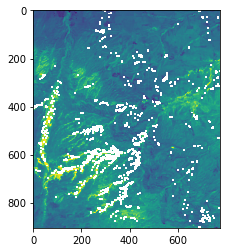

   interpolating daily biomass...
...completed in 207.0 secs
total elasped time: 35.35 mins



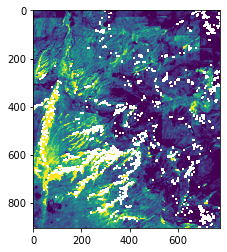

<AxesSubplot:>

In [26]:
# combine the available NDVI data with the output Dataset template
#dat_out_ds.attrs = hls_ds.attrs
dat_out_ds['NDVI_despike'] = despike_ts_xr(dat_out_ds['NDVI'].chunk({'y': 5, 'x': 5, 'time':-1}), 
                                           dat_thresh=0.07, 
                                           mask_outliers=False,
                                           iters=2,
                                           dims=['time'])
dat_out_ds['NDVI_smooth'] = smooth_xr(dat_out_ds['NDVI_despike'], 
                                      dims=['time'], 
                                      kwargs={'double': True, 'limit': 91})
dat_out_ds['Biomass_despike'] = despike_ts_xr(dat_out_ds['Biomass'].chunk({'y': 5, 'x': 5, 'time':-1}),
                                              dat_thresh=150, 
                                              mask_outliers=True,
                                              z_thresh=5.0,
                                              iters=2,
                                              dims=['time'])
dat_out_ds['Biomass_smooth'] = smooth_xr(dat_out_ds['Biomass_despike'], 
                                         dims=['time'],
                                         kwargs={'double': True, 'limit': 91})
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

t1 = time.time()
print('   interpolating daily NDVI...')
dat_out_ds['NDVI_smooth'] = dat_out_ds['NDVI_smooth'].compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

show(dat_out_ds['NDVI_smooth'].isel(time=200), vmin=0.10, vmax=0.35)

t1 = time.time()
print('   interpolating daily biomass...')
dat_out_ds['Biomass_smooth'] = dat_out_ds['Biomass_smooth'].compute()
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

show(dat_out_ds['Biomass_smooth'].isel(time=200), vmin=250, vmax=1000)

In [28]:
t1 = time.time()
if subunit_name is not None:
    print('   adding pasture data as a spatial coordinate...')
    aoi_info = df_aoi[[subunit_name, 'geometry']].reset_index(drop=True).reset_index().rename(columns={'index': 'id'})
    past_dict = {row.id+1: row.Pasture for _, row in aoi_info.iterrows()}
    past_dict[0] = 'UNK'
    aoi_mask_shp = [(row.geometry, row.id+1) for _, row in aoi_info.iterrows()]
    aoi_mask = shp2mask(shp=aoi_mask_shp, 
                         transform=rio.Affine(30.0, 0.0, dat_out_ds.x.min(), 0.0, -30.0, dat_out_ds.y.max()), 
                         outshape=dat_out_ds['NDVI'].shape[1:], 
                         xr_object=dat_out_ds['NDVI'])
    past_mask = np.array([past_dict[i] for i in aoi_mask.values.flatten()]).reshape(aoi_mask.shape)
    dat_out_ds = dat_out_ds.assign(Pasture=(['y', 'x'], past_mask)).chunk({'y': 50, 'x': 50})
    dat_out_ds = dat_out_ds.set_coords(subunit_name)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

    show(dat_out_ds['NDVI_smooth'].isel(time=200).where(
        dat_out_ds[subunit_name].isin(list(df_aoi[subunit_name].unique()[:5]))))

t1 = time.time()
print('   subsetting data to ' + str(yr) + ' only and saving to disk as geotiffs...')
yr_mask = dat_out_ds['time'].astype(np.datetime64).dt.year == yr
dat_out_ds.sel(time=yr_mask)

if not os.path.exists(os.path.join(outDIR, 'hls_ndvi/')):
    os.mkdir(os.path.join(outDIR, 'hls_ndvi/'))
if not os.path.exists(os.path.join(outDIR, 'hls_biomass/')):
    os.mkdir(os.path.join(outDIR, 'hls_biomass/'))

dat_out_ds.sel(
    time=yr_mask)['NDVI_smooth'].astype('float32').rio.to_raster(
    os.path.join(outDIR, 'hls_ndvi/' + prefix + '_hls_ndvi_' + str(yr) + '.tif'))
dat_out_ds.sel(
    time=yr_mask)['Biomass_smooth'].astype('int16').rio.to_raster(
    os.path.join(outDIR, 'hls_biomass/' + prefix + '_hls_bm_' + str(yr) + '.tif'))
print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

if subunit_name is not None:
    t1 = time.time()
    print('   computing daily averages for individual subunits and saving to disk...')
    df_out_aoi = dat_out_ds.sel(
        time=yr_mask).mean(dim=['y', 'x']).to_dataframe()

    df_out_aoi[subunit_name] = 'AOI'
    df_out_aoi = df_out_aoi.drop(columns='epsg').reset_index()

    df_out_pasts = dat_out_ds.sel(
        time=yr_mask).groupby(subunit_name).mean(dim='stacked_y_x').to_dataframe()

    df_out_pasts = df_out_pasts.drop(columns='epsg').reset_index()

    df_out_all = pd.concat([df_out_aoi, df_out_pasts])
    df_out_all.rename(columns={'time': 'Date'}, inplace=True)

    df_out_all.loc[:,
                   [c for c in df_out_all.columns if 'NDVI' in c]] = df_out_all.loc[:,
                                                                                    [c for c in df_out_all.columns if 'NDVI' in c]].apply(
        lambda x: round(x, 4))
    df_out_all.loc[:,
                   [c for c in df_out_all.columns if 'Biomass' in c]] = df_out_all.loc[:,
                                                                                    [c for c in df_out_all.columns if 'Biomass' in c]].apply(
        lambda x: round(x, 0))

    df_out_all[df_out_all[subunit_name] != 'UNK'].sort_values(
        [subunit_name, 'Date']).to_csv(
        os.path.join(outDIR, 'output/' + prefix + '_hls_means/' + prefix + '_hls_means_' + str(yr) + '.csv'),
        index=False)
    print('...completed in ' + str(round(time.time() - t1, 0)) + ' secs')
    print('total elasped time: ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')


    print('checking output dataframe NDVI data')
    ax1 = df_out_all[df_out_all[subunit_name]=='AOI'].plot('Date', 'NDVI_smooth', c='orange')
    df_out_all[df_out_all[subunit_name]=='AOI'].plot.scatter('Date', 'NDVI', ax=ax1)
    df_out_all[df_out_all[subunit_name]==df_aoi[subunit_name].unique()[0]].plot('Date', 
                                                                                'NDVI_smooth', 
                                                                                c='red',
                                                                                ax=ax1)
    df_out_all[df_out_all[subunit_name]==df_aoi[subunit_name].unique()[1]].plot('Date',
                                                                                'NDVI_smooth',
                                                                                c='blue', 
                                                                                ax=ax1)
    plt.show()
    plt.close()

    print('checking output dataframe biomass data')
    ax2 = df_out_all[df_out_all[subunit_name]=='AOI'].plot('Date', 'Biomass_smooth', c='orange')
    df_out_all[df_out_all[subunit_name]=='AOI'].plot.scatter('Date', 'Biomass', ax=ax2)
    df_out_all[df_out_all[subunit_name]==df_aoi[subunit_name].unique()[0]].plot('Date', 
                                                                                'Biomass_smooth',
                                                                                c='red',
                                                                                ax=ax2)
    df_out_all[df_out_all[subunit_name]==df_aoi[subunit_name].unique()[1]].plot('Date', 
                                                                                'Biomass_smooth',
                                                                                c='blue', 
                                                                                ax=ax2)
    plt.show()
    plt.close()

print('all analysis complete for year ' + str(yr) + '. Finished in ' + str(round((time.time() - t0)/60, 2)) + ' mins\n')

   subsetting data to 2022 only and saving to disk as geotiffs...


/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


...completed in 15.0 secs
total elasped time: 40.52 mins

all analysis complete for year 2022. Finished in 40.52 mins



In [8]:
dask.distributed.TimeoutError

asyncio.exceptions.TimeoutError

In [17]:
dat_out_ds['NDVI_smooth'].isel(time=200)#.where(dat_out_ds[subunit_name].isin(df_aoi[subunit_name].unique()[:5]))

<xarray.DataArray 'NDVI_smooth' (time: 486, y: 323, x: 323)>
dask.array<xarray-NDVI_smooth, shape=(486, 323, 323), dtype=float64, chunksize=(486, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2021-11-01 2021-11-02 ... 2023-02-28 2023-03-01
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    epsg     int64 32613
    Pasture  (y, x) <U7 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [29]:
dat_out_ds['NDVI_smooth'].isel(time=200).where(dat_out_ds[subunit_name].isin(list(df_aoi[subunit_name].unique()[:5])))

<xarray.DataArray 'NDVI_smooth' (y: 323, x: 323)>
dask.array<where, shape=(323, 323), dtype=float64, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
    time     object 2022-05-20
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    epsg     int64 32613
    Pasture  (y, x) <U7 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [27]:
list(df_aoi[subunit_name].unique()[:5])

['10S', '10SNE', '11NS', '11NW', '12C']